# Verification and Validation

Now we have a working solver (the fast version of SOR) we need to know if
* we are solving the the right equations?
* we are solving the equations right?

These two questions are related to the process of Validation and Verification (often called V&V).   

The fist question asks if the PDE we are solving is a proper representation of the physical problem we are trying to understand.  More on this later.

The second is all about the errors in our solution. We need to think about sources of error in our calculation and decide if our solver is behaving properly.

## Sources of Error
1. Round off - Are the numerical equations implemented in a way which maintains accuracy?  Are we using a sufficiently precise representation of the numbers?
2. Implementation - Have we got bugs in the code? 
3. Accuracy - In solving the equations have we acheived a sufficient degree of convergence?
4. Truncation - The order of accuracy of our numerical scheme.

To look at this we need a solver (which needs some libraries and our Grid class).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Grid:
    '''Class defining a 2D computational grid.  The grid object
    contains is a regular cartesian grid with a single variable, u.
    It stores information about the number of grid points in the i
    and j directions, the ordinates of these points and the bottom
    left corner of the gird (the origin) and the top right corner
    (the extent).
    
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.'''
    
    def __init__(self,ni,nj):
        # set up information about the grid
        self.origin = (0.0, 0.0)  # bottom left
        self.extent = (1.0, 1.0)  # top right
        self.Ni = ni # grid points in i direction
        self.Nj = nj # grid points in j direction
        
        # initialse x,y and u arrays
        self.u = np.zeros((nj, ni))
        self.x = np.zeros((nj, ni))
        self.y = np.zeros((nj, ni))

    def set_origin(self,x0,y0):
        self.origin = (x0, y0)
    
    def set_extent(self,x1,y1):
        self.extent = (x1, y1)
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.extent[0], self.Ni)
        y_ord = np.linspace(self.origin[1], self.extent[1], self.Nj)
        self.x, self.y = np.meshgrid(x_ord,y_ord)
        if not Quiet:
            print(self)

    def Delta_x(self):
        # calculate delta x
        return self.x[0,1]-self.x[0,0]
    
    def Delta_y(self):
        # calculate delta y
        return self.y[1,0]-self.y[0,0]
    
    def find(self,point):
        '''find the i and j ordinates of the grid cell which contains 
        the point (x,y).  To do this we calculate the distance from
        the point to the origin in the x and y directions and then
        divide this by delta x and delta y.  The resulting real ordinates
        are converted to indices using the int() function.'''
        grid_x = (point[0] - self.origin[0])/self.Delta_x()
        grid_y = (point[1] - self.origin[1])/self.Delta_y()
        return int(grid_x), int(grid_y)
    
    def __str__(self):
        # describe the object when asked to print it
        return 'Uniform {}x{} grid from {} to {}.'.format(self.Ni, self.Nj, self.origin, self.extent)
    
def SOR(mesh,tol=0.5e-7,maxit=10000):
    '''Sucessive over Relaxation method for the solution of
    the Laplace equation with checkerboarding.  The solver 
    assumes a uniform Cartesian mesh and uses the optimal
    value of the acceleration parameter, omega.
    
    The method works on the grid stored in the mesh object.  
    It will continue itterating until the relative difference 
    between u^{n+1} and u^n is less than tol. It will also stop 
    if we have done more than maxit itterations.
    
    The solution stored in the mesh.u variable is updated
            
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.'''

    # calculate the optimal value of omega
    lamda = (np.cos(np.pi/mesh.Ni)+np.cos(np.pi/mesh.Nj))**2/4
    omega = 2/(1+np.sqrt(1-lamda))

    # calculate the coefficients
    beta = mesh.Delta_x()/mesh.Delta_y()
    beta_sq = beta**2
    C_beta = 1/(2*(1+beta_sq))
    
    # initialise u_new 
    u_new = mesh.u.copy()
    
    # build the list of k values    
    offset = mesh.u.shape[1] # how far away are j+1 and j-1

    # create some empty lists
    centre = []; north = []; east = []; south=[]; west = []  
    # loop over all the interior points
    for j in range(1,mesh.Nj-1):
        for i in range(1,mesh.Ni-1):
            k=i+offset*j  # calculate the k value
            # save the south, west, centre, east and north points
            centre.append(k)
            north.append(k+offset)
            east.append(k+1)
            south.append(k-offset)
            west.append(k-1)

    # itteration
    for it in range(maxit):
        
        # red squares [::2] means from 0 to n in steps of 2, remember
        # we are taking alternate values from the lists centre, east,
        # north, west and south and using them as indicies into the 
        # u_new array.
        u_new.flat[centre[::2]] = (1-omega) * u_new.flat[centre[::2]] + \
                                    omega * C_beta*(u_new.flat[north[::2]]+ \
                                    u_new.flat[south[::2]]+ \
                                    beta_sq*(u_new.flat[east[::2]]+ \
                                             u_new.flat[west[::2]]))
        
        # black squares [1::2] means from 1 to n in steps of 2
        u_new.flat[centre[1::2]] = (1-omega) * u_new.flat[centre[1::2]] + \
                                    omega * C_beta*(u_new.flat[north[1::2]]+ \
                                    u_new.flat[south[1::2]]+ \
                                    beta_sq*(u_new.flat[east[1::2]]+ \
                                             u_new.flat[west[1::2]]))

        # compute the difference between the new and old solutions
        err = np.max(np.abs(mesh.u-u_new))
        
        # update the solution
        mesh.u = np.copy(u_new)
        
        # converged?
        if err < tol:
            break
    
    if it+1 == maxit:
        print('Checkerboard Gauss-Seidel itteration failed to converge, error = {}'.format(err))
    return it+1,err

## The test problem
Were going to use the same test problem as before:  

$$0=u_{xx}+u_{yy}$$
subject to the boundary conditions
$$\begin{align*}
u(x,0)&=0&0\le x\le 2 \\
u(x,1)&=0&0\le x\le 2 \\
u(0,y)&=0&0\le y \le 1\\
u(2,y)&=\sin 2\pi y&0\le y \le 1.
\end{align*}$$


In [2]:
def Example929(ni,nj):
    # set up a mesh
    mesh = Grid(ni,nj)
    mesh.set_extent(2.0,1.0)
    mesh.generate()
    # now the RHS boundary condition
    mesh.u[:,-1]=np.sin(2*np.pi*mesh.y[:,-1])
    return mesh

In [3]:
# Test problem on a fine grid
test = Example929(161,81)


## Round off

The `numpy.finfo()` function can be used to tell us some useful information about the representation of numbers in Python.  If we apply this to the u array, we get:

In [4]:
info  = np.finfo(test.u.dtype)
print(info)

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



This tells us
* u is stored as a 64 bit (8 byte) floating point number.
* we have approximately 15 decimal places of accuracy
* 11 bits are used to store the exponent which can be between (-1022 and 1024)
* the smallest representible number (at which a number becomes indistinguishable from zero) is 2.2250738585072014e-308
* the largest representible number (at which an overflow error occurs) is 1.7976931348623157e+308
* the largest number, ε, for which 1 + ε = 1 is 2.2204460492503131e-16

Double precision is considered standard for most numeric computations.  We can use more precision but this will slow down the computation.

The ammount of memory used to store u is 8 times the size of u:

In [5]:
print('{:.0f} kbytes'.format(test.u.size*8/1024))

102 kbytes


## Implementation

Now we need to check for bugs in the code. 

Oddly the best way to do this is to try to solve probkems where we know **nothing** should happen.  If we solve
$$0=u_{xx}+u_{yy}$$
subject to the boundary conditions
$$\begin{align*}
u(x,0)&=0&0\le x\le 1 \\
u(x,1)&=0&0\le x\le 1 \\
u(0,y)&=0&0\le y \le 1\\
u(1,y)&=0&0\le y \le 1.
\end{align*}$$
starting with the initial conditions $$u(x,y)=0$$ nothing should change.

In [6]:
nulltest = Grid(11,11)
nulltest.generate()
itt, err = SOR(nulltest)
print('Converged after {} itterations, final residual is {}'.format(itt,err))
print(nulltest.u)

Converged after 1 itterations, final residual is 0.0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Now we can try again with a problem where u is zero and all the boundary conditions are 1.  We are going to set `tol = 1.0e-15` to ensure that we have a completely converged solution! 

In [7]:
nulltest.u[:,:] = 1
nulltest.u[1:-1,1:-1] = 0
print(nulltest.u)
itt, err = SOR(nulltest,tol=1e-15)
print('Converged after {} itterations, final residual is {}'.format(itt,err))
print(nulltest.u)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Converged after 63 itterations, final residual is 6.661338147750939e-16
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


## Accuracy

For problem 9.29 we have an analytical solution,
$$u=\sin2\pi y\frac{\sinh 2\pi x}{\sinh 4\pi}.$$

If we create a model solution we can compare the two, looking at the error between them.  This can be done eirther by plotting the local error against x and y or by calculating the L2 norm:
$$||e(x,y)||_2=\sqrt{\sum_i\sum_j e^2_{ij}}$$

We don't have to do this by hand as numpy provides the function `numpy.linalg.norm()` to compute the L2 norm.

We need a function to compute the analytical solution and then we want to compare.  In this case I'm going to use a high value of `tol=0.5e-4` which will give us around 4 decimal places of accuracy.

Solver took 0.701 seconds.
Converged after 146 itterations, final residual is 4.606725047696249e-05
L2 norm = 0.006046492778863192


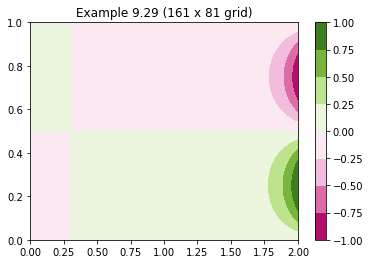

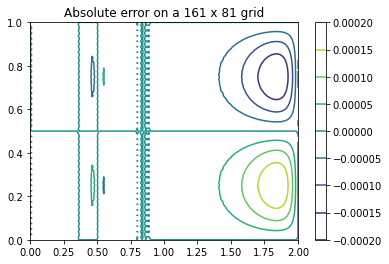

In [8]:
def analytical929(mesh):
    # take a copy of the u array
    u = np.copy(mesh.u)
    # calculate the analytical solution
    u[:,:] = np.sin(2*np.pi*mesh.y)*np.sinh(2*np.pi*mesh.x)/np.sinh(4*np.pi)
    return u

exact = analytical929(test)

start = time.process_time()
itt, err = SOR(test,tol=0.5e-4)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt,err))

err = test.u - exact
print('L2 norm =',np.linalg.norm(err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test.x,test.y,test.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test.Ni} x {test.Nj} grid)')
plt.show()

# plot the error
fig, ax1 = plt.subplots()
cf = ax1.contour(test.x,test.y,err)
ax1.set_title(f'Absolute error on a {test.Ni} x {test.Nj} grid')
fig.colorbar(cf, ax=ax1)
plt.show()

You can see that the We could try converging further, setting `tol=1.0e-15`.  If we call the solver again without re-initialising test we will just continue from where we were,

Solver took an additional 4.12 seconds.
Converged after 987 itterations, final residual is 9.992007221626409e-16
L2 norm = 0.005798100391264446


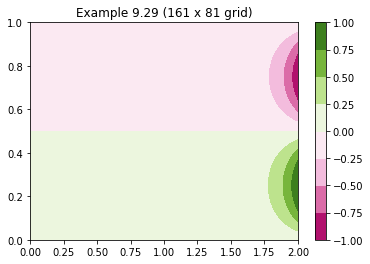

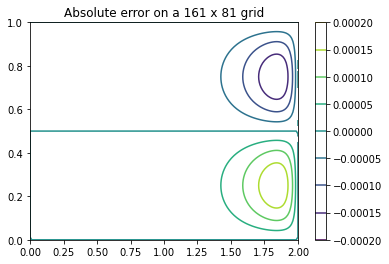

In [9]:
start = time.process_time()
it2, err = SOR(test,tol=1e-15)
stop = time.process_time()
print("Solver took an additional {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt+it2,err))

err = test.u - exact
print('L2 norm =',np.linalg.norm(err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test.x,test.y,test.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test.Ni} x {test.Nj} grid)')
plt.show()

# plot the error
fig, ax1 = plt.subplots()
cf = ax1.contour(test.x,test.y,err)
ax1.set_title(f'Absolute error on a {test.Ni} x {test.Nj} grid')
fig.colorbar(cf, ax=ax1)
plt.show()

## Truncation error
Now we know we have an accurate and precise (i.e. properly implemented with accurate arithmetic) solution, we see if the truncation error is behaving the way we expect.  Remember that the central difference approximation to the 2nd derivative is:
$$\frac{\partial^2 u}{\partial x^2} = \frac{u_W-2u_O+u_E}{\Delta x^2}+O(\Delta x^2).$$

Since the truncation error is O(Δx<sup>2</sup>) we expect the errors to decrease proortionately to Δx<sup>2</sup>.

The GCI analysis (see the lecture) allows us to:
* estimate the apparent order of accuracy, p (i.e. the errors are decreasing proportionate to Δx<sup>p</sup>), and
* test to see if the grid is sufficiently fine that this is the case.

Recall that we need:
* a sequence of grids (N=1, 2, 3 ... ) where Δx and Δy approximately double each time (N=1 is the finest grid).
* an integrated quantity which we measure over the same region of the domain on each grid. I'm going to use
$$U=\int_{1.0}^{1.95}u(x,0.25)\,dx$$
* some routines to compute p, the Grid Convergence Index and to estimate U on a grid where Δx=0.

Were going to use the `refinement_analysis` class which can be downloaded from LEARN. It should be placed in the same directory as this Jupyter notebook.  We also need a function to do the integration (we can use  Simpson's rule from `scipy.integrate`)  to do this and the `find` function from the `Grid` class.


In [10]:
import scipy.integrate as integrate
from refinement_analysis import refinement_analysis

def integrate_u_dx(mesh,x0,x1,y):
    '''Calculate U=\int_{1.0}^{1.95)u(x,0.25) dx  using the
    u value stored on the grid and simpsons rule'''
    
    # find the left and right grid points
    i0,j = mesh.find((x0,y))
    i1,j = mesh.find((x1,y))

    # add 1 to i1 as we are going to use it as an upper 
    # bound forarray slicing
    i1 = i1 +1
    
    # integrate
    return integrate.simps(mesh.u[j,i0:i1],mesh.x[j,i0:i1])


    

We then need to set up a sequence of grids based on grid doubling. The number of grid points in each direction should be given by $$N =2^n m + 1$$ where n is the grid index and m is an integer.  For our problem we are going to use
$$N_i=2^n 20 + 1\text{ and }N_j=2^n 10 + 1$$

The following script creates a sequence of grids and solves them all.  The upper limit on the `range(5,-1,-1)` is the grid index of the finest grid.  Grid 7 takes about 40 minutes to run on my macbook pro. Grid 6, takes a much more reasonable three and a half minutes. 


In [11]:
import datetime # just seconds may not be enough

# we need some lists u and dx values
U_val = []
dx_val = []
run_time = []
n_pts =[]
for grid_index in range(6,-1,-1):
    ni = 20*2**grid_index + 1
    nj = 10*2**grid_index + 1
    n_pts.append(ni*nj)
    
    # set up the problem
    test = Example929(ni,nj)
    print(test)
    
    # solve it with 14 d.p. precision and a lot of itterations
    start = time.process_time()
    itt, err = SOR(test,tol=0.5e-14,maxit=1000000)
    stop = time.process_time()
    print("The solver converged after {} itterations, it took {}, final residual is {}" \
          .format(itt,datetime.timedelta(seconds=int(stop-start)),err))

    # save dx and the integral
    dx_val.append(test.Delta_x())
    U_val.append(integrate_u_dx(test,1.0,1.95,0.25))
    run_time.append(stop-start)
          
    print('Integrated value is ',U_val[-1],'\n')

Uniform 1281x641 grid from (0.0, 0.0) to (2.0, 1.0).
The solver converged after 4061 itterations, it took 0:47:17, final residual is 4.9960036108132044e-15
Integrated value is  0.11595119458119807 

Uniform 641x321 grid from (0.0, 0.0) to (2.0, 1.0).
The solver converged after 2018 itterations, it took 0:05:59, final residual is 4.884981308350689e-15
Integrated value is  0.11595482347649985 

Uniform 321x161 grid from (0.0, 0.0) to (2.0, 1.0).
The solver converged after 1020 itterations, it took 0:00:38, final residual is 4.827735433643454e-15
Integrated value is  0.11596933925855846 

Uniform 161x81 grid from (0.0, 0.0) to (2.0, 1.0).
The solver converged after 517 itterations, it took 0:00:03, final residual is 4.911869522228329e-15
Integrated value is  0.11602740558304181 

Uniform 81x41 grid from (0.0, 0.0) to (2.0, 1.0).
The solver converged after 264 itterations, it took 0:00:00, final residual is 3.845881946240581e-15
Integrated value is  0.11625972091743786 

Uniform 41x21 grid

Refinement Analysis on 7 grids.

Grid Delta x ratio  \int_{1.0}^{1.95}u(x,0.25) dx
-------------------------------------------------
   1 0.001563     2  0.115951
   2 0.003125     2  0.115955
   3 0.00625     2  0.115969
   4  0.0125     2  0.116027
   5   0.025     2   0.11626
   6    0.05     2  0.117316
   7     0.1   --- 0.0853199
------------------------------------------------- 

order of convergence, p =   2.00

Grids       GCI
---------------
 1  2 1.304e-05
 2  3 5.216e-05
 3  4 0.0002086
 4  5 0.0008343
 5  6  0.003787
 6  7    0.1136
---------------

 Grid Step  GCI Ratio Converged
-------------------------------
 1 2  2 3           1 True
 2 3  3 4           1 True
 3 4  4 5           1 True
 4 5  5 6      0.8812 False
 5 6  6 7      0.1333 False
-------------------------------



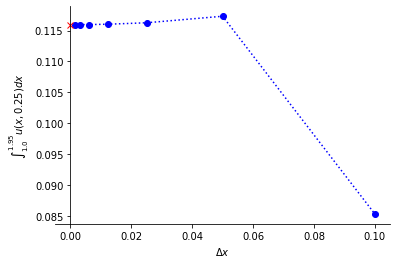

In [12]:
# lets to the refinement analysis
analysis = refinement_analysis(dx_val,U_val)
analysis.report(r'\int_{1.0}^{1.95}u(x,0.25) dx')
analysis.plot(True,r'$\int_{1.0}^{1.95}u(x,0.25) dx$')

### Analysis

The refinement analysis shows
* _p_ = 2.0, so our 2nd order method has an apparent order of accuracy of 2.  Which is reasuring.
* The graph shows that the coarsest grid (Δx = 0.1) is behaving differently from the other grids which seem to be converging as Δx goes to zero.
* The GCI Ratios show that the solution on the five finest grids is safely in the asymptotic region where the error is proprtional to Δx<sup>2</sup>.  This means (for the test problem) we need Δx < 0.025 m. This means we need to use at least the 81 x 41 gird. Which takes less than 1 second to run.

Our final choice of grid depends on 
* How accurate a solution we want, and
* How long we are prepared to wait.

All this means that the 161 x 81 grid (grid 4, Δx=0.0125) we've been using is fine enough to give a **grid converged** solution and we can be confident that the solution can be used.   If we are prepared to wait a little longer than 2 seconds we can use the 321 x 161 grid and wait 20 seconds for a more accurate answer.

## Runtime
It's interesting to look at the time taken to get a solution on different sizes of grid. The following log-log graph shows the totoal number of grid points (i.e. _N_ = _Ni_ x _Nj_) plotted against the runtime in seconds.  Plotted like this we can see there is a dramatic increase in the work needed with increasing _N_.  It can be shown that the number of mathematical opperations performed is O(_N_<sup>2</sup>_m_) where _m_ is the number of itterations performed.  

Although SOR converges faster than Gauss-Siedel and Jacobi all three can only be proved to converge after an infinite number of itterations.  

Faster (but more complicated) Krylov subspace methods can be used which converge in a finite number of itterations. Fortunately for us `scipy.linalg` provides some efficient implementations of these methods which will be looked at in annother workbook.

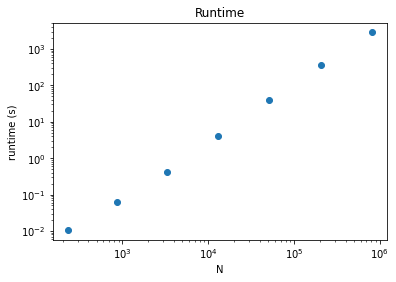

In [13]:
# plot the runtime
plt.loglog(n_pts,run_time,'o')
plt.title('Runtime')
plt.xlabel('N')
plt.ylabel('runtime (s)')
plt.show()